#Tarea 03 - Análisis de datos geoespaciales mediante pandas, plotly, geopandas y folium



## Estudiantes:

Daniel Salazar Mora - B87214
<br/>
Stephanie María Leitón Ramírez - B74106


##Importando las bibliotecas

In [1]:
import os
import requests
import zipfile
import csv
from functools import partial
from shapely.geometry import Point, mapping, shape
from shapely.ops import transform
!pip install fiona
!pip install owslib
!pip install geojson
from owslib.wfs import WebFeatureService
from geojson import dump
import fiona
import fiona.crs

     |████████████████████████████████| 16.7 MB 286 kB/s 
     |████████████████████████████████| 216 kB 6.6 MB/s 
     |████████████████████████████████| 6.3 MB 42.9 MB/s 


In [2]:
# Instalación de bibliotecas de GDAL para Python
!apt install gdal-bin python-gdal python3-gdal

# Instalación de r-tree
!apt install python3-rtree

# Instalación de GeoPandas
!pip install git+git://github.com/geopandas/geopandas.git

# Instalación de Descartes
!pip install descartes

!pip install contextily

!pip install folium

import math
import folium
import geopandas as gpad
import pandas as pd
import contextily as cx
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
from folium import Marker
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  python-numpy-doc python3-nose python3-numpy-dbg
The following NEW packages will be installed:
  python3-gdal python3-numpy
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 2,288 kB of archives.
After this operation, 13.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-numpy amd64 1:1.13.3-2ubuntu1 [1,943 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python3-gdal amd64 2.2.3+dfsg-2 [346 kB]
Fetched 2,288 kB in 2s (1,459 kB/s)
Selecting previously unselected

##Obtención de datos
Se usan las capas de Web Feature Service (WFS) publicadas por el Instituto Geográfico Nacional (IGN) en el Sistema Nacional de Información Territorial (SNIT):

Límite cantonal 1:5000
https://www.snitcr.go.cr/ico_servicios_ogc_info?k=bm9kbzo6MjY=&nombre=IGN%20Cartograf%C3%ADa%201:5mil
 
 <br/>

Red vial 1:200000
https://www.snitcr.go.cr/ico_servicios_ogc_info?k=bm9kbzo6NDI=&nombre=IGN%201:200mil


### Limite Cantonal

In [40]:
#wfs = WebFeatureService(url='https://geos.snitcr.go.cr/be/IGN_5/wfs?', version='1.1.0')
#list(wfs.contents)

In [41]:
# Título
#wfs.identification.title

In [42]:
# Operaciones
#[operation.name for operation in wfs.operations]

In [43]:
# Solicitud de metadatos del servicio

# Parámetros de la solicitud
params = dict(service='WFS', version='1.1.0', request='GetCapabilities')

# Solicitud
response = requests.get("https://geos.snitcr.go.cr/be/IGN_5/wfs?", params=params)

# Despliegue del contenido de la respuesta
#response.content

In [44]:
# Solicitud de capa WFS de Limite Cantonal mediante GET, para retornarse como JSON

# Parámetros de la solicitud
params = dict(service='WFS',
              version='1.1.0', 
              request='GetFeature', 
              typeName='IGN_5:limitecantonal_5k',
              srsName='urn:ogc:def:crs:EPSG::5367',
              outputFormat='json')

# Solicitud
response = requests.get("https://geos.snitcr.go.cr/be/IGN_5/wfs?", params=params)

In [46]:
# Descarga de la respuesta en un archivo GeoJSON
os.mkdir('/content/datos')
with open('/content/datos/cantones.geojson', 'w') as file:
   dump(response.json(), file)

### Red Vial

In [47]:
wfs = WebFeatureService(url='https://geos.snitcr.go.cr/be/IGN_200/wfs?version=1.1.0', version='1.1.0')
#list(wfs.contents)

In [48]:
# Título
#wfs.identification.title

In [49]:
# Operaciones
#[operation.name for operation in wfs.operations]

In [50]:
# Solicitud de metadatos del servicio

# Parámetros de la solicitud
params = dict(service='WFS', version='1.1.0', request='GetCapabilities')

# Solicitud
response = requests.get("https://geos.snitcr.go.cr/be/IGN_200/wfs?version=1.1.0", params=params)

# Despliegue del contenido de la respuesta
#response.content

In [51]:
# Solicitud de capa WFS de Red Vial mediante GET, para retornarse como JSON

# Parámetros de la solicitud
params = dict(service='WFS',
              version='1.1.0', 
              request='GetFeature', 
              typeName='IGN_200:redvial_200k',
              srsName='urn:ogc:def:crs:EPSG::5367',
              outputFormat='json')

# Solicitud
response = requests.get("https://geos.snitcr.go.cr/be/IGN_200/wfs?version=1.1.0", params=params)

In [52]:
# Descarga de la respuesta en un archivo GeoJSON
with open('/content/datos/redvial.geojson', 'w') as file:
   dump(response.json(), file)

## Creación de un archivo GeoPackage con todas las capas

In [15]:
# Se agrega el archivo GeoJSON de asp-especies al GPKG

with fiona.open('/content/datos/cantones.geojson') as source:
    with fiona.open('/content/datos/geo_cantones.gpkg', 'w', 'GPKG', source.schema, source.crs, layer='cantones') as sink:
        for record in source:
            sink.write(record)

In [16]:
with fiona.open('/content/datos/redvial.geojson') as source:
    with fiona.open('/content/datos/geo_redvial.gpkg', 'w', 'GPKG', source.schema, source.crs, layer='redesviales') as sink:
        for record in source:
            sink.write(record)

In [17]:
from shapely.geometry.linestring import LineString

'''
  El nombre del cantón.                                                            ⚪
  La longitud de las autopistas.                                                   ⚪
  La longitud de las carreteras de pavimento de dos vías o más.                    ⚪
  La longitud de las carreteras de pavimento de una vía.                           ⚪
  La longitud de las carreteras sin pavimento de dos vías.                         ⚪
  La longitud de los caminos de tierra.                                            ⚪
  La longitud total (i.e. todos los tipos de red vial) de la red vial del cantón.  ⚪
  La densidad total (i.e. todos los tipos de red vial) de la red vial del cantón.  ⚪
'''
camino_tierra = 'CAMINO DE TIERRA'
camino_pavimento_2v = 'CARRETERA PAVIMENTO DOS VIAS O MAS'
camino_pavimento_1v = 'CARRETERA PAVIMENTO UNA VIA'
camino_sin_pavimento_2v = 'CARRETERA SIN PAVIMENTO DOS VIAS'
autopista = 'AUTOPISTA'


# Nuevo esquema que tendrá los datos de cada cantón, más la longitud de sus redes viales y la densidad
schema = {'geometry':'Unknown',
          'properties':{'id':'str',
                        'canton':'str',
                        'area':'float',
                        'longitud':'float',
                        'densidad':'float',
                        'long_autopistas': 'float',
                        'long_pavimento_1v':'float',
                        'long_pavimento_2v':'float',
                        'long_sin_pavimento_2v':'float',
                        'long_tierra':'float'
                        
                       }}

with fiona.collection('datos/geo_cantones.gpkg', 'r', layer='cantones') as cantones:
    
    i = 1 # contador para ver progreso
    
    with fiona.open('datos/redvial_por_canton.geojson','w','GeoJSON', schema, cantones.crs) as redvial_cantonal:
    
        for canton in cantones:
            #print(i, canton['properties']['canton'])
            longitud_total_por_canton = 0
            densidad = 0
            camino_tierra_total = 0
            camino_pavimento_2v_total = 0
            camino_pavimento_1v_total = 0
            camino_sin_pavimento_2v_total = 0
            autopista_total = 0
            area = float(canton['properties']['area'])  

            with fiona.collection('datos/geo_redvial.gpkg', 'r', layer='redesviales') as redesviales:
                for redvial in redesviales:
                  # Si existe una interseccion, se sumara su longitud a la longitud total dentro de ese canton
                  if shape(redvial['geometry']).intersects(shape(canton['geometry'])):
                    red = shape(canton['geometry']).intersection(shape(redvial['geometry']))
                    longitud_total_por_canton += red.length
                    if redvial['properties']['categoria'] == autopista:
                      autopista_total += red.length
                    elif redvial['properties']['categoria'] == camino_pavimento_2v:
                      camino_pavimento_2v_total += red.length
                    elif redvial['properties']['categoria'] == camino_pavimento_1v:
                      camino_pavimento_1v_total += red.length
                    elif redvial['properties']['categoria'] == camino_sin_pavimento_2v:
                      camino_sin_pavimento_2v_total += red.length
                    elif redvial['properties']['categoria'] == camino_tierra:
                      camino_tierra_total  += red.length

            i += 1
            
            longitud_total_por_canton = (longitud_total_por_canton / 1000) # se pasa a km
            camino_tierra_total = camino_tierra_total/1000
            camino_pavimento_2v_total = camino_pavimento_2v_total/1000
            camino_pavimento_1v_total = camino_pavimento_1v_total/1000
            camino_sin_pavimento_2v_total = camino_sin_pavimento_2v_total/1000
            autopista_total = autopista_total/1000
            densidad = (longitud_total_por_canton / area)   
            #print(" Longitud: ", str(longitud_total_por_canton))

            # Se escriben los datos para la nueva capa
            redvial_cantonal.write({
                'properties': {
                    'id':canton['properties']['id'],
                    'canton':canton['properties']['canton'],
                    'area': area,
                    'longitud': longitud_total_por_canton,
                    'densidad': densidad,
                    'long_autopistas': autopista_total,
                    'long_pavimento_1v':camino_pavimento_1v_total,
                    'long_pavimento_2v':camino_pavimento_2v_total,
                    'long_sin_pavimento_2v':camino_sin_pavimento_2v_total,
                    'long_tierra':camino_tierra_total
                },
                'geometry':canton['geometry']
            }) 

In [18]:
# Se agrega el archivo GeoJSON final a un GeoPackage
with fiona.open('datos/redvial_por_canton.geojson') as source:
    with fiona.open('datos/geo_redvial_por_canton.gpkg', 'w', 'GPKG', source.schema, source.crs, layer='redvial_por_canton') as sink:
        for record in source:
            sink.write(record)


##Tabla con los 82 cantones de Costa Rica

In [19]:
# Cargar el GeoJason en un dataframe de pandas
pandas_file = gpad.read_file('datos/redvial_por_canton.geojson')
#Tabla de pandas con las columnas específicas
pandas_file[['canton', 'area','longitud','densidad','long_autopistas','long_pavimento_1v','long_pavimento_2v','long_sin_pavimento_2v','long_tierra']]

,canton,area,longitud,densidad,long_autopistas,long_pavimento_1v,long_pavimento_2v,long_sin_pavimento_2v,long_tierra
0,Corredores,623.61,495.824322,0.795087,0.0,99.151474,130.679910,12.139449,253.853488
1,Golfito,1752.75,602.680436,0.343848,0.0,127.669233,80.781497,72.046381,322.183324
2,Coto Brus,944.24,747.302687,0.791433,0.0,369.560745,108.759457,0.000000,268.982485
3,Osa,1932.70,678.898893,0.351270,0.0,153.449033,134.506071,55.998104,334.945685
4,Buenos Aires,2382.94,1297.086045,0.544322,0.0,434.423277,170.930288,0.000000,691.732481
...,...,...,...,...,...,...,...,...,...
77,Guatuso,752.83,308.730568,0.410093,0.0,76.574171,19.648571,0.000000,212.507827
78,Los Chiles,1332.71,776.987780,0.583013,0.0,228.786538,114.471868,0.000000,433.729374
79,Liberia,1442.17,1070.443021,0.742245,0.0,278.803923,39.948298,0.000000,751.690800
80,Upala,1592.67,770.134477,0.483549,0.0,418.678393,9.263710,2.904216,339.288158


##Gráfico plotly de barras 

Text(0, 0.5, 'Longitud')

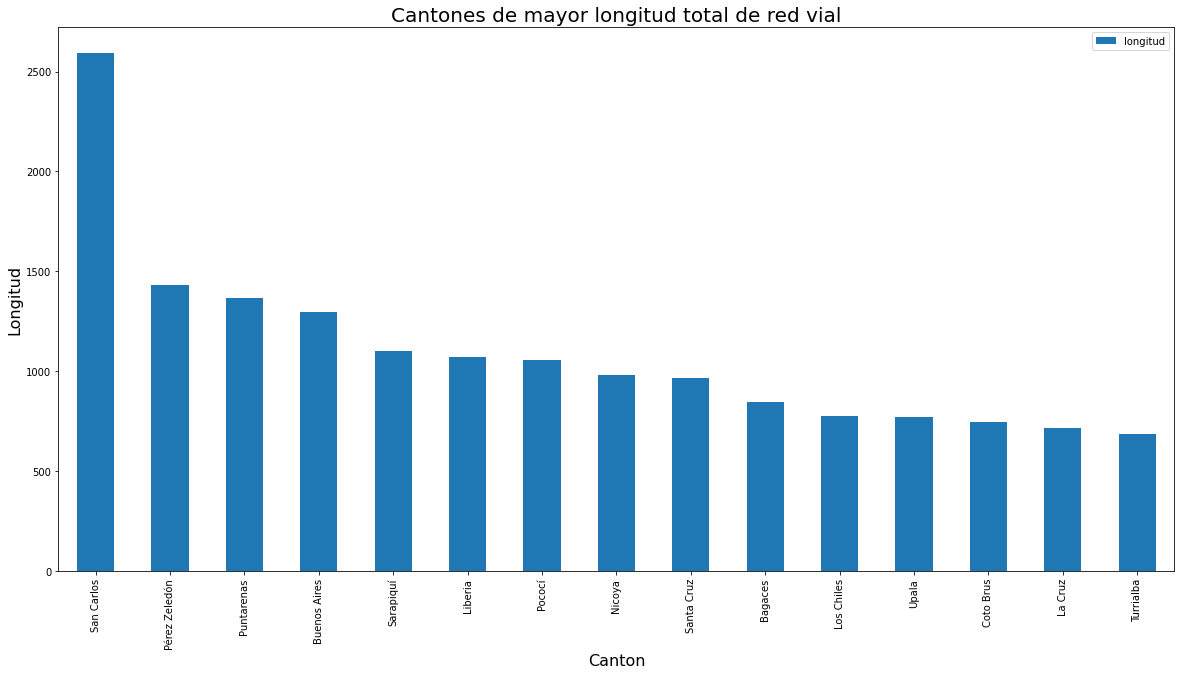

In [20]:
#Extraer las 15 cantones de mayor longitud total de red vial
# Dataframe filtrado para usar en graficación
longitud_grafico = pandas_file[['canton', 'longitud']].sort_values("longitud", ascending=[False]).head(15)
#Gráfico plotly de barras apiladas 
longitud_grafico.plot(x='canton',y='longitud',kind='bar',figsize=(20,10))

# Título y leyendas en los ejes
plt.title('Cantones de mayor longitud total de red vial', fontsize=20)
plt.xlabel('Canton', fontsize=16)
plt.ylabel('Longitud', fontsize=16)

##Gráfico plotly de pastel 

Porcentaje de red vial de los 15 cantones de mayor longitud total de la red vial, con respecto a la longitud de la red vial en todo el país.
La porción (slice) adicional en el gráfico de pastel llamada “Otros cantones”, correspondiente al porcentaje de la suma de la red vial en los 67 cantones restantes."

In [39]:
#ordenar los valores por longitud
pastel = pandas_file[['canton', 'longitud']].sort_values("longitud", ascending=[False])
#reset al index
pastel = pastel.reset_index()
#extraer la longitud de valor 15
longitud_15= pastel['longitud'].loc[14]
#cambiar el canton a los siguientes valores luego del 15
pastel.loc[pastel['longitud'] < longitud_15 , 'canton'] = 'Otros cantones' 
#Gráfico plotly de pastel 
fig = px.pie(pastel, values='longitud', names='canton', title='Porcentaje de los 15 cantones de mayor longitud total de la red vial en el país')
fig.show()

##Mapa folium 
Un mapa folium con las siguientes capas:
* Capa base (OpenStreetMap, Stamen, etc.).
* Capa de coropletas correspondiente a la densidad de la red vial en los cantones.
* Líneas de la red vial.
<br />
Y los siguientes controles:
* Control para activar y desactivar capas.
* Escala


In [22]:
# Cargar el GeoJason en un dataframe de pandas
densidad = gpad.read_file('/content/datos/redvial_por_canton.geojson')
# Cargar el GeoJason en un dataframe de pandas
cantones_file = gpad.read_file('/content/datos/cantones.geojson')

In [38]:
# Creación del mapa base
mapa= folium.Map(
    location=[9.8, -84], 
    width=1000, height=1000, 
    zoom_start=8,
    control_scale=True,
    tiles='Stamen Watercolor'
    )
'''
#Añadir mapa de coropletas
folium.Choropleth(
    name="Densidad de la red vial en los cantones de Costa Rica",
    geo_data=cantones_file,
    data=densidad,
    columns=['id', 'densidad'],
    bins=8,
    key_on='feature.properties.id',
    fill_color='Reds', 
    fill_opacity=0.5, 
    line_opacity=1,
    legend_name='Densidad',
    smooth_factor=0).add_to(mapa)
'''
#añadir capa con las lineas de red vial
#folium.GeoJson(data="/content/datos/redvial.geojson", name='Red vial').add_to(mapa)

# Control de capas
folium.LayerControl().add_to(mapa)

# Despliegue del mapa
mapa
